In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import e
from marchMadnessBracket.torch_bracket import *
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from marchMadnessBracket.data.bracket_2021 import teams, human_picks
from marchMadnessBracket.utils import realistic_game_logisitic, color_fader,r_squared
import numpy as np
import matplotlib as mpl
'''plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
'''

import pickle

In [2]:
ratings = []
names = []
for team in teams:
    ratings.append(team.rating)
    names.append(team.name)

In [3]:
TB = TorchBracket(teams)

<function matplotlib.pyplot.legend(*args, **kwargs)>

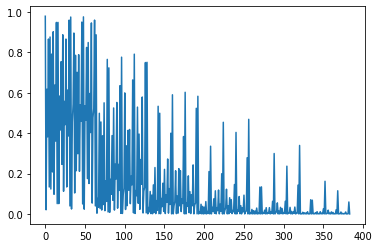

In [4]:
prob = TB.prob_multi_level_flat()
prob = prob.detach().numpy()
plt.plot(prob)
plt.legend

In [5]:
target = make_target_from_human_picks(human_picks,names)

In [6]:
def make_plots(TB,target, post_fix=""):
    prob = TB.prob_multi_level()
    target = target.view(TB.n_rounds,-1)
    
    prob_np = prob.detach().numpy()
    target_np = target.detach().numpy()
    
    c1='#1f77b4' #blue
    c2='red' #green
    n=6
    colors = color_fader(c1,c2,n)
    print("r_squared: ",r_squared(target_np,prob_np))
    for i, (pnp, tnp, c) in enumerate(zip(prob_np,target_np, colors)):
        plt.scatter(pnp,tnp, label = "Round: {}".format(i), color=c, alpha=.5)
    plt.title("Target prob vs Simulated probability")
    plt.xlabel("Target prob")
    plt.ylabel("Simulated prob")
    plt.legend()
    plt.show()
    plt.savefig("output/targeted_vs_sim_single_value_{}.pdf".format(post_fix))
    
    for i, (pnp, tnp, c) in enumerate(zip(prob_np,target_np, colors)):
        r2 = r_squared(tnp,pnp)
        print("r2: ", r2)
        plt.clf()
        plt.scatter(pnp,tnp, label = "Round: {} ".format(i), color=c, alpha=1)
        plt.title("Target prob vs Simulated probability: round {} (R Sqr.={:.2f})".format(i,r2))
        plt.xlabel("Target prob")
        plt.ylabel("Simulated prob")
        x = np.linspace(0,1,3)
        plt.plot(x,x, color="black",linestyle=":")
        plt.legend()
        plt.savefig("output/targeted_vs_sim_single_value_{}_pretraining.pdf".format(i))
        plt.show()
        

r_squared:  0.9485788941383362


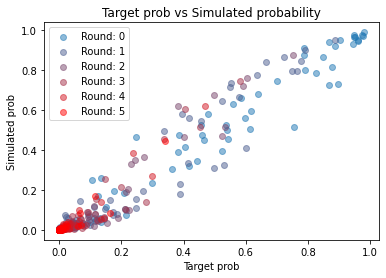

r2:  0.9464934766292572


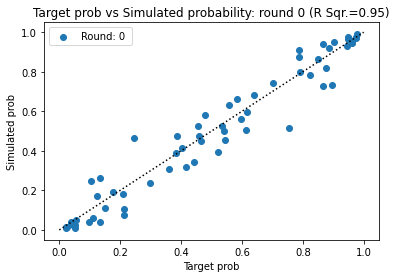

r2:  0.9017137438058853


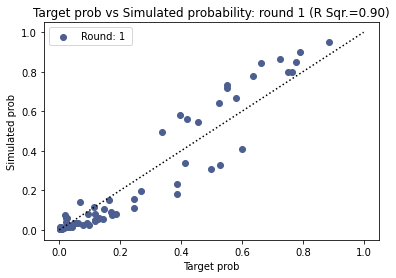

r2:  0.9054547399282455


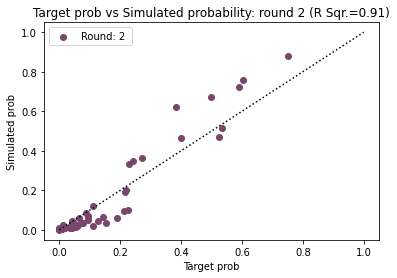

r2:  0.8871117681264877


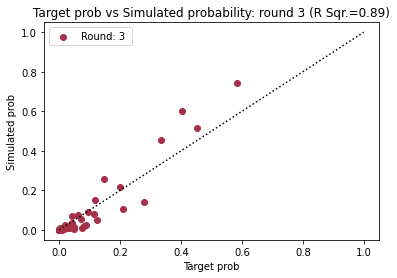

r2:  0.8896532282233238


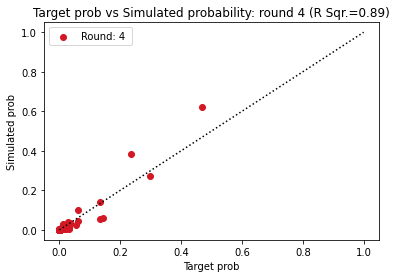

r2:  0.8885474652051926


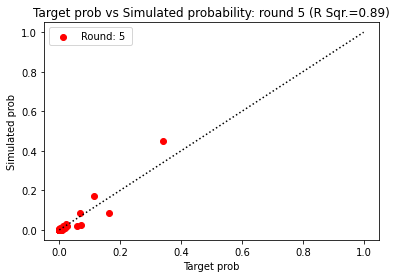

In [7]:
make_plots(TB,target, post_fix="pre_fit")

In [8]:
loss_func = nn.MSELoss()

In [9]:
optimizer = torch.optim.Adam([TB.ratings_tensor], lr=1e-3)
losses =[]

0 0.0038501034
100 0.0034902224
200 0.0031693617
300 0.0028827935
400 0.0026262554
500 0.002395961
600 0.0021885848
700 0.002001324
800 0.0018318262
900 0.0016780823
1000 0.0015383409
1100 0.0014110705
1200 0.0012949266
1300 0.0011887387
1400 0.00109149
1500 0.0010023039
1600 0.00092042173
1700 0.0008451882
1800 0.0007760344
1900 0.0007124641
2000 0.0006540417
2100 0.0006003782
2200 0.0005511217
2300 0.0005059557
2400 0.00046458523
2500 0.00042673745
2600 0.00039215852
2700 0.00036060903
2800 0.0003318649
2900 0.00030571435
3000 0.0002819579
3100 0.00026040737
3200 0.00024088532
3300 0.000223224
3400 0.00020726748
3500 0.00019286743
3600 0.00017988613
3700 0.00016819457
3800 0.00015767291
3900 0.00014821046
4000 0.00013970496
4100 0.0001320616
4200 0.00012519502
4300 0.00011902609
4400 0.00011348344
4500 0.00010850237
4600 0.00010402414
4700 9.999582e-05
4800 9.6369746e-05
4900 9.310296e-05
5000 9.0156995e-05
5100 8.749723e-05
5200 8.509261e-05
5300 8.291535e-05
5400 8.094068e-05
5500 

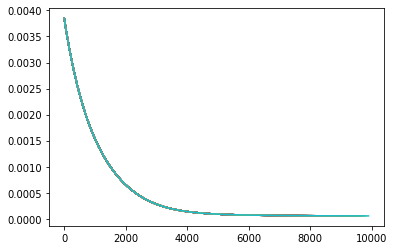

In [10]:
for i in range(10000):
    optimizer.zero_grad()
    prob = TB.prob_multi_level_flat()
    loss = loss_func(prob,target)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()
    if i%100==0:
        print(i,loss.detach().numpy())
        plt.plot(losses)
        #print(ratings_tensor)


In [14]:
TB.set_teams()

In [15]:
computer_rating = TB.starting_rating()
human_rating = TB.trained_rating()

In [20]:
names_prob = list(zip(names,computer_rating,human_rating,human_rating-computer_rating))
print("{},{},{},{}".format("Team", "Infered human rating", "Computer rating", "diff"))
for name, hr, tr, diff in sorted(names_prob,key=lambda x: -x[1]):
    print("{},{:.2f},{},{:.2f}".format(name, hr, tr, diff))

Team,Infered human rating,Computer rating,diff
Gonzaga,25.90,29.81449317932129,3.91
Baylor,23.10,24.10215187072754,1.00
Illinois,21.70,25.5642147064209,3.86
Iowa,20.90,21.170988082885742,0.27
Michigan,20.40,23.270780563354492,2.87
Houston,19.90,18.880544662475586,-1.02
Alabama,18.00,20.316436767578125,2.32
Villanova,17.90,15.664582252502441,-2.24
Ohio St.,17.50,20.295591354370117,2.80
Kansas,17.10,19.165428161621094,2.07
Creighton,16.90,14.309592247009277,-2.59
Texas Tech,16.90,13.656694412231445,-3.24
Florida St.,16.70,17.52542495727539,0.83
Texas,16.50,19.02474594116211,2.52
Tennessee,16.50,14.625788688659668,-1.87
Virginia,16.20,17.371339797973633,1.17
Arkansas,16.20,15.635007858276367,-0.56
West Virginia,16.20,18.125076293945312,1.93
Colorado,16.00,13.130143165588379,-2.87
USC,15.90,13.80908489227295,-2.09
Wisconsin,15.90,13.27176284790039,-2.63
Connecticut,15.20,12.252985000610352,-2.95
Purdue,15.20,15.148026466369629,-0.05
N. Carolina,14.90,14.074117660522461,-0.83
LSU,14.60,13.0

r_squared:  0.9992495807819068


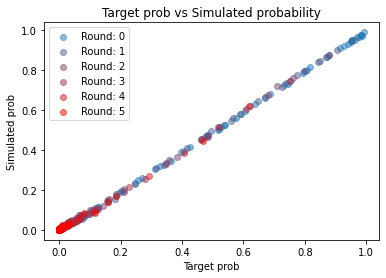

r2:  0.999173870368395


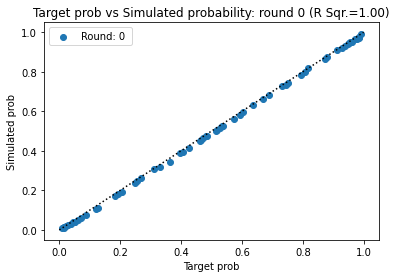

r2:  0.9992001630016603


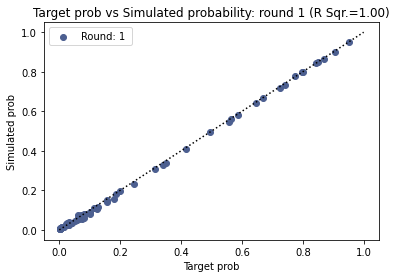

r2:  0.9987820843234658


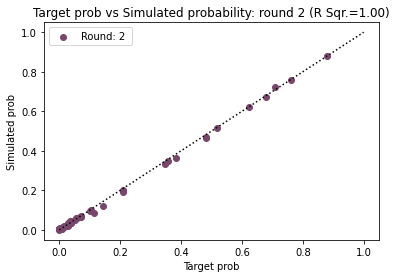

r2:  0.9978760404046625


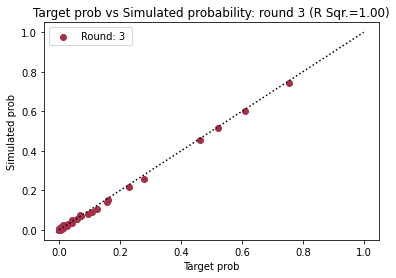

r2:  0.995970378164202


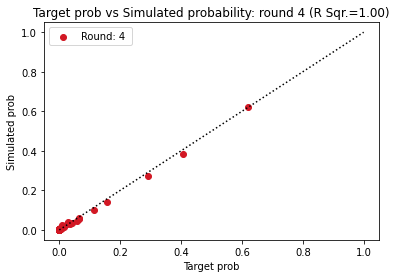

r2:  0.9908313872292638


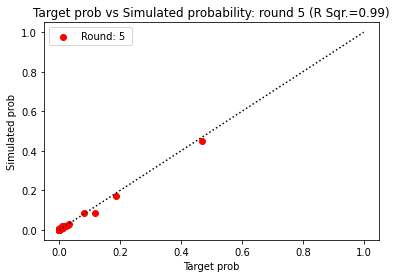

In [21]:
make_plots(TB,target, post_fix="post_fit")

In [22]:
with open("trained_bracket.pkl", 'wb') as f:
    pickle.dump(TB,f)

Demonstration of similarity between logistic vs norm cdf for 2*e base

In [17]:
from scipy.stats import norm

x = np.linspace(-20,20,100)
norm = norm.cdf(x, loc=0, scale=9.5)
logisitic = (1/(1+(e*2)**(-(x)/9.5) ) )

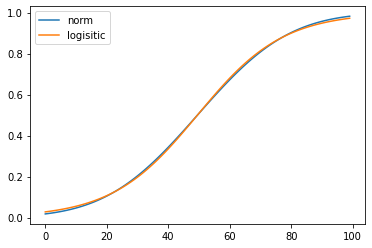

In [18]:
plt.plot(norm, label="norm")
plt.plot(logisitic, label="logisitic")
plt.legend()